# Multi-class Dog Breed Classification

This notebook will build a multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.

## Problem
 
Identifying the breed of a dog given an image of a dog using a neural network.

## Data

The data is from Kaggle's Dog Breed Identification competition that can be found [here](https://www.kaggle.com/competitions/dog-breed-identification/overview).

## Evaluation

According to the Kaggle's evaluation, we will be "evaluated on Multi Class Log Loss between the predicted probability and the observed target."

## Features
- We have images (unstructed data) so we'll be using a neural net/transfer learning.
- There are 120 breeds of dogs in the dataset thus there are 120 different classes.
- We are working with more than 10,000 images in the training set and 10,000 images in the test set.

## Getting The Workspace Ready

In [1]:
# Import tensorflow
import matplotlib.pyplot as plt
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.9.1


In [2]:
# Import tensorflow hub
import tensorflow_hub as hub

print(f"Tensorflow Hub Version: {hub.__version__}")

Tensorflow Hub Version: 0.12.0


In [3]:
# Check if GPU is available
print(f"GPU is{'' if tf.config.list_physical_devices('GPU') else ' not'} available")

GPU is available


2022-06-14 23:02:32.111444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 23:02:32.148055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 23:02:32.148310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Data Preparation
As we are working with image data, we'll need to convert it into numeric data so that the models will be able to run on the dataset.

Let's first check the labels of our data.

In [4]:
import pandas as pd
import numpy as np

labels_csv = pd.read_csv("data/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [5]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


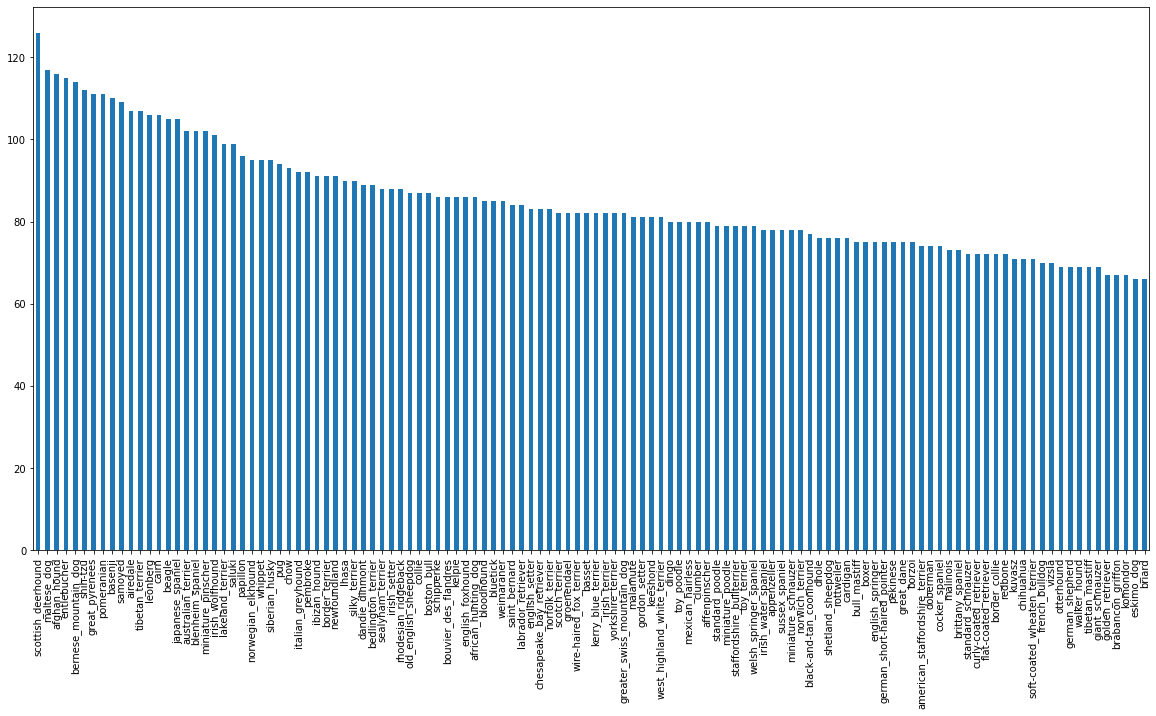

In [6]:
# How many images are there of each breed?
print(labels_csv["breed"].value_counts())
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

It seems like the classes with the fewest images have 66 images which seems to be enough for building our model.

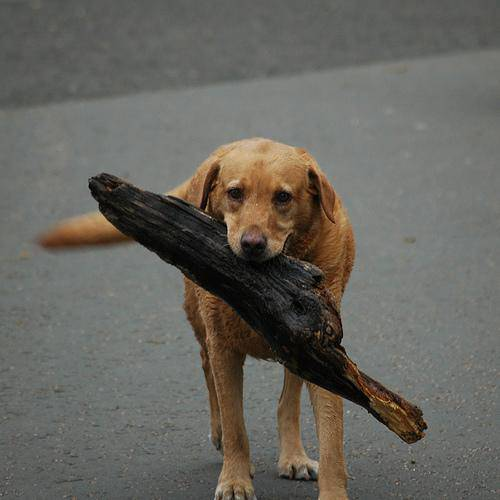

In [7]:
# Let's view one of our dog images
from IPython.display import Image

Image("data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting Images and Their Labels
Let's get a list of all our image file paths.

In [8]:
# Create file paths from our image ID's
file_paths = labels_csv["id"].apply(lambda x: "data/train/" + x + ".jpg").tolist()
file_paths[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
len(file_paths)

10222

In [10]:
# Check whether number of file paths match the actual number of training images
import os

if len(os.listdir("data/train")) == len(file_paths):
    print("Number of file paths match number of training images")
else:
    print("Number of file paths do not match")

Number of file paths match number of training images


### Preparing Labels
Let's look at our labels and prepare them as well.

In [11]:
# convert labels to numpy array
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# How many labels do we have
len(labels)

10222

In [13]:
# Make sure there are the same number of images and labels
if len(file_paths) == len(labels):
    print("Number of labels matches number of images")
else:
    print("Number of labels do not match number of images")

Number of labels matches number of images


In [14]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
# Number of dog breeds should be 120
len(unique_breeds)

120

In [16]:
# One hot encode our labels where 1 represents that the label is that breed in the same position in the unique_breeds array
encoded_labels = [(label == unique_breeds).astype(int) for label in labels]
encoded_labels[:3]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 

### Creating our Validation Set
As the data source (Kaggle) only provides a training and testing set, we will want to create our own validation set.

In [17]:
X = file_paths
y = encoded_labels

As we have more than 10,000 images, we will start off by experimenting with ~2000 images, and increase the number as needed.

In [18]:
NUM_IMAGES = 2000

In [19]:
# Let's split out data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)

len(X_train), len(y_train), len(X_valid), len(y_valid)

(1600, 1600, 400, 400)

In [20]:
X_train[:2]

['data/train/17c5e8815cf0d086090a07b003b9b036.jpg',
 'data/train/0593e37870ee77b0d34508e118bf6670.jpg']

In [21]:
y_train[:2]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

## Preprocessing Images

We will be turning our images into tensors for our model.
To do this, we will be writing a function that:
1. Takes an image filepath as a parameter
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` jpg into tensors
4. Standardize our image (convert the colours from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return `image`

In [22]:
def process_image_path(file_path: str, img_size: int = 224) -> tf.Tensor:
    """
    Takes an image file path and turns the image into a tensor.

    :param file_path: File path of an image
    :param img_size: Size of the output image (default = 224x224)
    :return img: The image of the file path as a tensor
    """
    # Read in the image file
    img = tf.io.read_file(file_path)
    # Turn the image into a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Standardize the tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize and return the image
    return tf.image.resize(img, size=[img_size, img_size])

## Turning our Data into Mini-Batches

I will be using 32 images as our mini-batch size at the moment.

In order to use TensorFlow effectively, we need our data to be in the form of tensor tuples `(image, label)`.

In [23]:
def get_image_label(file_path: str, label: np.ndarray) -> tuple[tf.Tensor, np.ndarray]:
    """
    Takes an image file path, and it's corresponding label.
    Returns the processed image and label as a tuple

    :param file_path: File path of an image
    :param label: The label for the image
    :return img, label: A tuple of the image tensor and it's label
    """
    img = process_image_path(file_path)
    return img, label

After creating this function to transform our data into tuples of tensors, let's write a function to create mini-batches.

In [24]:
from typing import Optional


def create_data_batches(X: list[str], y: Optional[list[int]] = None, batch_size: int = 32, valid_data: bool = False,
                        test_data: bool = False):
    """
    Creates mini batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).

    :param X: Image file names
    :param y: Image labels
    :param batch_size: The size of the batches (default = 32)
    :param valid_data: Boolean to represent if the data is validation data (default = False)
    :param test_data: Boolean to represent if the data is testing data (default = False)
    :return: Data batches in the form (image, labels)
    """

    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print("Creating test data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))  # only file paths (no labels)
        data_batch = data.map(process_image_path).batch(batch_size)

    # If the data is a validation dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # file paths
                                                   tf.constant(y)))  # labels
        data_batch = data.map(get_image_label).batch(batch_size)

    else:
        print("Creating training data batches")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffle the file paths and labels
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)

    return data_batch

In [25]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating training data batches
Creating validation data batches


2022-06-14 23:02:33.742424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 23:02:33.744578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 23:02:33.744903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 23:02:33.745116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [26]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int32, name=None)))

## Visualising the Data Batches

Now that the data is in batches, it is a little difficult to comprehend what a batch looks like. So let's try to visualise what our batches look like.

In [27]:
import matplotlib.pyplot as plt


def preview_batch_images(images: np.ndarray, labels: np.ndarray) -> None:
    """
    Displays a plot of 25 images and their labels from a data batch.

    :param images: Array of images in a batch
    :param labels: Array of corresponding labels in a batch
    """

    plt.figure(figsize=(10, 10))
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i + 1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn off grid lines
        plt.axis("off")

In [28]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int32, name=None))>

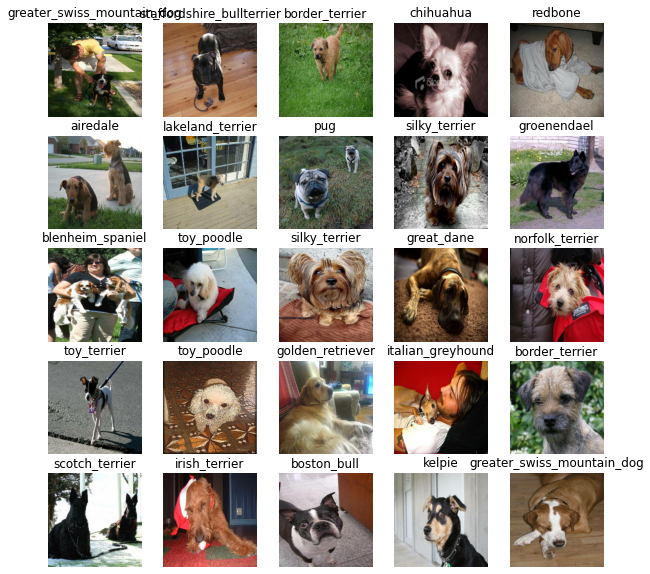

In [29]:
# Let's preview the training data
train_images, train_labels = next(train_data.as_numpy_iterator())
preview_batch_images(train_images, train_labels)

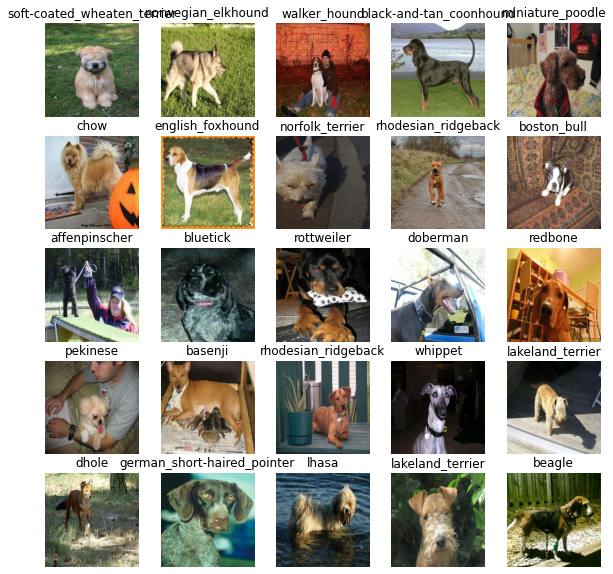

In [30]:
# Preview the validation data
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
preview_batch_images(valid_images, valid_labels)

## Model Building

Before we build a model, there are a few things we need to define:
- The input shape (our image's shape in the form of tensors) to our model.
- The output shape (image labels in the form of tensors) of our model.
- The URL of the model we want to use (as we are using tensorflow hub).

In [31]:
# Setup input shape to the model
IMG_SIZE = 224
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

Now that we've got the inputs, outputs, and models ready to go.

Let's create a function that:
- Takes the input shape, output shape, and the model we've chosen as parameters
- Defines the layers in a Keras model
- Compiles the model
- Builds the model
- Returns the model

In [32]:
# Model creation function
def create_model(input_shape: list[None, int] = INPUT_SHAPE, output_shape: int = OUTPUT_SHAPE,
                 model_url: str = MODEL_URL) -> tf.keras.Sequential:
    print(f"Building model with {model_url}")

    # Set up the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),  # Layer 1 (input layer),
        tf.keras.layers.Dense(units=output_shape,
                              activation="softmax")  # Layer 2 (output layer)
    ])
    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    # Build the model
    model.build(input_shape)

    return model

In [33]:
model = create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,628,953
Trainable params: 120,240
Non-trainable params: 5,508,713
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions that a model can use during training to do such things as saving its progress, checking its progress, or stop training early if the model has converged.

We'll create two callbacks, one for TensorBoard which helps track our model's progress, and another for early stopping which prevents our model from training too long and overfitting.


### TensorBoard Callback


In [34]:
%load_ext tensorboard

In [35]:
import datetime

def create_tensorboard_callback():
    # Create a log directory for storing Tensorboard logs
    log_dir = os.path.join("logs",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(log_dir)

### Early Stopping Callback
Early stopping helps our model from overfitting by stopping the training if the model has converged.

In [36]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5)

## Training a Model (on a subset of data)
Our first model is only going to train on 2000 images.

In [37]:
NUM_EPOCHS = 100

Let's create a function which trains a model.

- Create a model using `create_model()`
- Set up a Tensorboard callback using `create_tensorboard_callback()`
- Call the `fit()` method on our model passing it the training and validation data, number of epochs to train, and the callbacks we'd like to use.
- Return the model

In [38]:
def train_model() -> tf.keras.Sequential:
    """
    Trains a given model
    """
    # Create a model
    model = create_model()

    # Create new Tensorboard
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
              epochs=NUM_EPOCHS,
              validation_data=valid_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])

    return model

In [39]:
# Fit the model to the data
model = train_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5
Epoch 1/100


2022-06-14 23:02:53.921178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-06-14 23:02:58.502264: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


50/50 [==============================] - 26s 359ms/step - loss: 3.7146 - accuracy: 0.2500 - val_loss: 2.0117 - val_accuracy: 0.6125
Epoch 2/100
50/50 [==============================] - 15s 303ms/step - loss: 0.8979 - accuracy: 0.8281 - val_loss: 1.2420 - val_accuracy: 0.7000
Epoch 3/100
50/50 [==============================] - 14s 276ms/step - loss: 0.3348 - accuracy: 0.9531 - val_loss: 1.0639 - val_accuracy: 0.7300
Epoch 4/100
50/50 [==============================] - 14s 277ms/step - loss: 0.1755 - accuracy: 0.9881 - val_loss: 0.9910 - val_accuracy: 0.7300
Epoch 5/100
50/50 [==============================] - 14s 276ms/step - loss: 0.1108 - accuracy: 0.9962 - val_loss: 0.9644 - val_accuracy: 0.7475
Epoch 6/100
50/50 [==============================] - 15s 297ms/step - loss: 0.0775 - accuracy: 0.9994 - val_loss: 0.9372 - val_accuracy: 0.7525
Epoch 7/100
50/50 [==============================] - 16s 313ms/step - loss: 0.0589 - accuracy: 0.9994 - val_loss: 0.9265 - val_accuracy: 0.7525
Epoc

It looks like our model may be overfitting as it is performing way better on our training data compared to our validation accuracy. However, 76% accuracy on the validation set is still not too bad.
### Checking the TensorBoard Logs

In [40]:
%tensorboard --logdir logs

Launching TensorBoard...

## Making and Evaluating Predictions using a Trained Model

In [41]:
# Make predictions on the validation data
predictions = model.predict(valid_data, verbose=1)
predictions

13/13 [==============================] - 4s 267ms/step


array([[8.6529653e-06, 4.8318831e-03, 2.2820978e-04, ..., 6.1336257e-03,
        2.2844672e-04, 6.2106301e-05],
       [2.9528132e-05, 1.4640902e-06, 1.4958349e-05, ..., 1.4973023e-05,
        9.5924581e-05, 1.2656436e-05],
       [5.6921881e-06, 8.4427076e-05, 5.6416407e-06, ..., 6.2600608e-05,
        3.0802285e-06, 2.4069371e-04],
       ...,
       [2.5568028e-08, 6.2407998e-05, 1.2528211e-06, ..., 8.0407772e-06,
        5.5409851e-06, 8.0993923e-06],
       [1.4005997e-04, 1.4795164e-05, 1.2955605e-04, ..., 4.2667514e-05,
        4.7986740e-03, 2.4689201e-03],
       [7.7131454e-06, 7.9469219e-06, 1.4633943e-06, ..., 4.1134479e-07,
        4.4789817e-06, 1.4597034e-06]], dtype=float32)

In [42]:
predictions.shape

(400, 120)

In [43]:
# Turn prediction probabilities into their label
def get_pred_label(prediction_probabilities: np.ndarray) -> str:
    """
    Turns an array of prediction probabilities into a label

    :param prediction_probabilities: Array of prediction probabilities from a model
    :return: The predicted label (dog breed)
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

In [44]:
get_pred_label(predictions[5])

'chow'

Now since our validation data is still in a batch dataset, we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels.

In [45]:
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int32, name=None))>

In [46]:
def unbatchify(data: tf.data.Dataset) -> tuple[list[np.ndarray], list[np.ndarray]]:
    """
    Takes a batched dataset of (image, label) tensors and returns the images and labels as separate lists.

    :param data: The batched dataset.
    :return: Tuple containing a list of image arrays and a list of label arrays.
    """
    images = []
    labels = []

    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])

    return images, labels

In [47]:
valid_images, valid_labels = unbatchify(valid_data)

In [48]:
valid_images[0], valid_labels[0]

(array([[[0.28940946, 0.3325467 , 0.17568395],
         [0.2501433 , 0.29330748, 0.13644473],
         [0.2876167 , 0.3342017 , 0.17733893],
         ...,
         [0.5164206 , 0.5776601 , 0.33903962],
         [0.54773974, 0.6089793 , 0.3703588 ],
         [0.50159407, 0.56283355, 0.32421306]],
 
        [[0.27667817, 0.3276586 , 0.15903112],
         [0.30975384, 0.3608085 , 0.19218104],
         [0.33957785, 0.39721096, 0.22858347],
         ...,
         [0.491509  , 0.5575804 , 0.28604677],
         [0.5702347 , 0.6363061 , 0.36477253],
         [0.5313855 , 0.59745693, 0.32592332]],
 
        [[0.29069865, 0.35518688, 0.17861006],
         [0.29807582, 0.36118335, 0.18470922],
         [0.31007844, 0.37737536, 0.20058963],
         ...,
         [0.50055254, 0.56690407, 0.29036346],
         [0.5573835 , 0.623735  , 0.3471944 ],
         [0.55167574, 0.61802727, 0.34148666]],
 
        ...,
 
        [[0.24473517, 0.27916905, 0.13407102],
         [0.04194383, 0.08529994, 0.00537

Now we have ways to get:
- Predicted labels
- True validation labels
- Validation images

Let's try to visualise our predictions.

We'll create a function which:
- Takes an array of prediction probabilities, an array of true labels, and an integer.
- Convert the prediction probabilities to a predicted label.
- Plot the predicted label, its predicted probability, the truth label, and the target image on a single plot.

In [49]:
def plot_pred(prediction_probabilities: np.ndarray, images: list[np.ndarray], labels: list[np.ndarray], n: int = 1) -> None:
    """
    Plots an image at the n-th index with the predicted label, the prediction confidence, and the true label.
    :param prediction_probabilities: Array of prediction probabilities from a model
    :param images: List of image arrays
    :param labels: List of true label arrays
    :param n: The index of the prediction (default = 1)
    :return: Nothing
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Plot image & remove ticks
    plt.imshow(image)
    # plt.xticks([])
    # plt.yticks([])
    plt.axis("off")

    # Change the color of the title if the prediction is correct
    if true_label == pred_label:
        color = "green"
    else:
        color = "red"

    # Change plot title to be predicted, probability of prediction, and the true label
    plt.title(f"Pred: {pred_label} {np.max(pred_prob) * 100:.2f}% True: {true_label}",
              color=color)

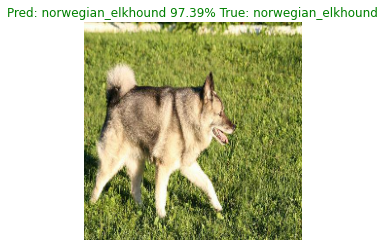

In [50]:
plot_pred(prediction_probabilities=predictions,
          images=valid_images,
          labels=valid_labels,
          n=1)

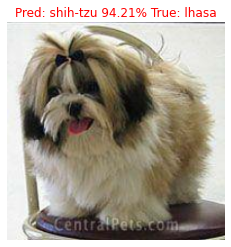

In [51]:
plot_pred(prediction_probabilities=predictions,
          images=valid_images,
          labels=valid_labels,
          n=50)

Now that we've got a function to visual our model's predictions, let's make another to view our model's top 10 predictions.

This function will:
- Take an input of prediction probabilities and a true labels array and an integer
- Find the prediction using `get_pred_label()`
- Find the top 10:
    - Prediction probability's indexes
    - Prediction probability's values
    - Prediction labels
- Plot the top 10 prediction probability values and labels, coloring the true label green.

In [52]:
def plot_pred_conf(prediction_probabilities: np.ndarray, labels: list[np.ndarray], n:int = 1):
    """
    Plots the top 10 highest prediction confidences along with the true label for sample n.
    :param prediction_probabilities: Array of prediction probabilities from a model
    :param labels: List of true label arrays
    :param n: The index of the prediction (default = 1)
    :return:
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Find the top 10 confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Set up plot
    top_10_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                          top_10_pred_values,
                          color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_10_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

    # Make the largest bar red if the predicted label is incorrect
    if pred_label != true_label:
        top_10_plot[0].set_color("red")

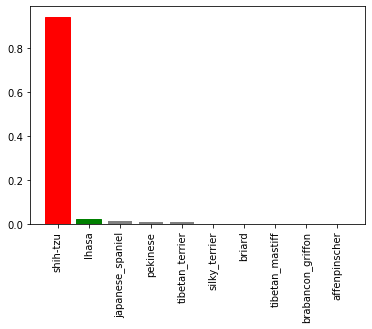

In [53]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=valid_labels,
               n=50)

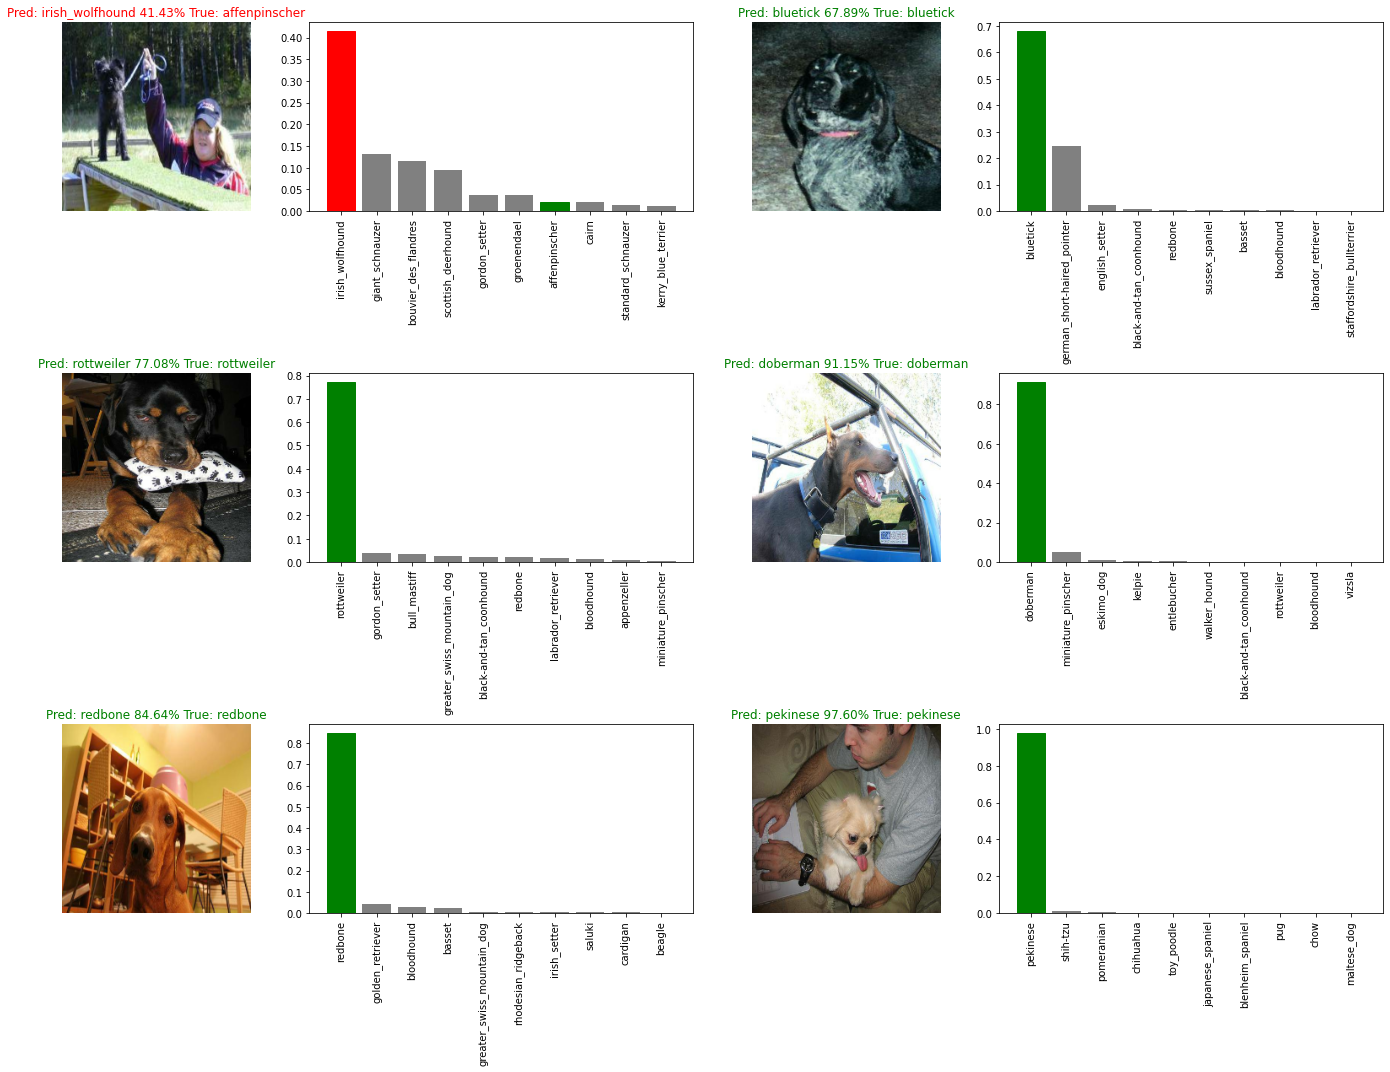

In [54]:
# Let's check out a few predictions and their different values
index_offset = 10
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize=(10 * num_cols, 5 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(prediction_probabilities=predictions,
              labels=valid_labels,
              images=valid_images,
              n=i + index_offset)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=valid_labels,
                   n=i + index_offset)
    plt.tight_layout(h_pad=1)
plt.show()

## Saving and Reloading a Trained Model

In [119]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string).

    :param model: A trained model
    :param suffix: Optional suffix for the model path (default = "")
    :return: The model path
    """
    model_dir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M"))
    model_path = f"{model_dir}{'-' + suffix if suffix else ''}.h5"

    print(f"Saving model to: {model_path}...")

    model.save(model_path)
    return model_path

In [122]:
# Create a function to load a model
def load_model(model_path: str):
    """
    Loads a model from a model path.

    :param model_path: The file path to the model
    :return: The model
    """
    print(f"Loading model from: {model_path}...")
    model = tf.keras.models.load_model(model_path,
                                       custom_objects = {"KerasLayer": hub.KerasLayer})
    return model

Now we have function to save and load trained models. Let's test them out.

In [120]:
# Save our model on 2000 images
save_model(model, suffix="2000-images-mobilenetv3-Adam")

Saving model to: models/20220615-0008-2000-images-mobilenetv3-Adam.h5...


'models/20220615-0008-2000-images-mobilenetv3-Adam.h5'

In [125]:
# Load the saved model
loaded_2000_image_model = load_model('models/20220615-0008-2000-images-mobilenetv3-Adam.h5')

Loading model from: models/20220615-0008-2000-images-mobilenetv3-Adam.h5...


In [126]:
# Evaluate the original model
model.evaluate(valid_data)

13/13 [==============================] - 3s 229ms/step - loss: 0.9019 - accuracy: 0.7600


[0.901888906955719, 0.7599999904632568]

In [127]:
# Evaluate the loaded model
loaded_2000_image_model.evaluate(valid_data)

13/13 [==============================] - 3s 218ms/step - loss: 0.9019 - accuracy: 0.7600


[0.901888906955719, 0.7599999904632568]

## Training a Model on the Whole Training Set

In [128]:
# Total number of samples
len(X), len(y)

(10222, 10222)

In [130]:
# Create a data batch with the full dataset
full_data = create_data_batches(X, y)

Creating training data batches


In [131]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.int32, name=None))>

In [132]:
# Create a model for full model
full_model = create_model()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5


In [133]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set as we are training on all the data
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=5)

**Note:** The following cell will take a little while to train as we  are training on the whole dataset.

In [134]:
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 14s 34ms/step - loss: 1.3672 - accuracy: 0.6719
Epoch 2/100
320/320 [==============================] - 10s 32ms/step - loss: 0.3879 - accuracy: 0.8860
Epoch 3/100
320/320 [==============================] - 10s 31ms/step - loss: 0.2204 - accuracy: 0.9400
Epoch 4/100
320/320 [==============================] - 10s 32ms/step - loss: 0.1418 - accuracy: 0.9654
Epoch 5/100
320/320 [==============================] - 10s 31ms/step - loss: 0.0958 - accuracy: 0.9821
Epoch 6/100
320/320 [==============================] - 10s 31ms/step - loss: 0.0675 - accuracy: 0.9913
Epoch 7/100
320/320 [==============================] - 10s 31ms/step - loss: 0.0509 - accuracy: 0.9945
Epoch 8/100
320/320 [==============================] - 10s 31ms/step - loss: 0.0402 - accuracy: 0.9965
Epoch 9/100
320/320 [==============================] - 10s 32ms/step - loss: 0.0320 - accuracy: 0.9975
Epoch 10/100
320/320 [==============================] - 11s 35ms/step - l

In [135]:
save_model(full_model, suffix="full-image-set-mobilenetv3-Adam")

Saving model to: models/20220615-0033-full-image-set-mobilenetv3-Adam.h5...


'models/20220615-0033-full-image-set-mobilenetv3-Adam.h5'

In [137]:
loaded_full_model = load_model('models/20220615-0033-full-image-set-mobilenetv3-Adam.h5')

Loading model from: models/20220615-0033-full-image-set-mobilenetv3-Adam.h5...


## Making Predictions on the Test Dataset
Since our model has been trained on images in the form of Tensor batches, we'll have to convert our test data into the same format.

To make predictions on the test data, we'll:
- Get the test image filenames
- Convert the filenames into data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels)
- Make a predictions array by passing the test batches to the `predict()` method on our model.

In [143]:
# Load test image files
test_path = "data/test/"
test_filenames = [test_path + filename for filename in os.listdir(test_path)]
test_filenames[:10]

['data/test/3e6d21074f78119df37d78ab8e96a9e3.jpg',
 'data/test/9f37e8ea16c98f6ab7034b4cc1f26a7b.jpg',
 'data/test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
 'data/test/38f7c638a61349ac2d10e676e371e386.jpg',
 'data/test/40b1f18fb2bec4a8ae46850f41e4df58.jpg',
 'data/test/c94cb08d0725ef8fe7647266def87b35.jpg',
 'data/test/f833a56026b89fba59f04d16ca6881d5.jpg',
 'data/test/b0af8261078235519a15edf051e083b3.jpg',
 'data/test/0e39ccd1021cefe374b0e38fd35b4356.jpg',
 'data/test/4909fc5b89f974fa007c12ba62ecf785.jpg']

In [144]:
len(test_filenames)

10357

In [145]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches


In [146]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [147]:
# Make predictions on test data batch
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 10s 31ms/step


In [148]:
# Have a little look at the test predictions
test_predictions

array([[4.26432479e-07, 2.50352750e-05, 6.40506983e-07, ...,
        3.20371873e-05, 1.06077420e-03, 2.00482724e-08],
       [2.06847481e-08, 1.06108744e-09, 2.20460900e-10, ...,
        9.80700960e-08, 8.03126836e-12, 1.66166657e-12],
       [1.70113612e-08, 4.14835495e-06, 5.62970670e-10, ...,
        9.41669001e-08, 1.48655740e-10, 1.46211114e-08],
       ...,
       [1.17517567e-11, 5.33959639e-12, 1.39092115e-11, ...,
        4.85533405e-07, 3.96091659e-10, 4.37401976e-10],
       [2.30915134e-10, 1.53967139e-09, 5.53242591e-11, ...,
        1.52323014e-06, 1.52939322e-06, 8.95962582e-10],
       [1.47636681e-10, 1.12523246e-09, 8.02563527e-09, ...,
        1.89968111e-10, 2.65306666e-10, 3.81883110e-12]], dtype=float32)

In [149]:
# Save predictions as a csv (for future use)
np.savetxt("test_predictions_array.csv", test_predictions, delimiter=",")

In [150]:
test_predictions.shape

(10357, 120)

## Preparing Test Predictions for Kaggle
Kaggle wants our submissions to be a dataframe with an image ID and a column for each dog breed.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
- Create a pandas Dataframe with an ID column as well as a column for each dog breed
- Add data to the ID column by extracting the test image IDs from their filepaths
- Add the prediction probabilities to each dog breed column
- Export as a csv

In [156]:
# Create a pandas dataframe
df = pd.DataFrame(columns=["id"] + unique_breeds.tolist())
df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [159]:
# Append test image IDs to the dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
df["id"] = test_ids

In [160]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,3e6d21074f78119df37d78ab8e96a9e3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9f37e8ea16c98f6ab7034b4cc1f26a7b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ad7e50abca9b7c6a88b63946c5bbe493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38f7c638a61349ac2d10e676e371e386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40b1f18fb2bec4a8ae46850f41e4df58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
# Add the prediction probabilities to each dog breed column
df[unique_breeds.tolist()] = test_predictions
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,3e6d21074f78119df37d78ab8e96a9e3,4.264325e-07,2.503528e-05,6.405070e-07,1.109797e-05,1.242454e-05,3.803995e-07,8.034293e-07,2.066200e-08,9.675561e-02,...,1.376876e-06,8.721518e-09,9.299675e-05,2.072434e-06,2.689188e-03,2.659335e-05,8.772189e-08,3.203719e-05,1.060774e-03,2.004827e-08
1,9f37e8ea16c98f6ab7034b4cc1f26a7b,2.068475e-08,1.061087e-09,2.204609e-10,1.603851e-11,2.523396e-10,9.178983e-15,3.158946e-13,4.493499e-11,2.697127e-11,...,1.837683e-10,8.046650e-15,2.868651e-08,8.182274e-11,2.733194e-09,4.301176e-11,1.285125e-10,9.807010e-08,8.031268e-12,1.661667e-12
2,ad7e50abca9b7c6a88b63946c5bbe493,1.701136e-08,4.148355e-06,5.629707e-10,6.617376e-11,1.717544e-09,7.054500e-11,1.073681e-12,5.307068e-11,3.783492e-11,...,5.407717e-11,1.620973e-13,1.042109e-09,2.163827e-10,5.959638e-08,1.201785e-11,4.678740e-11,9.416690e-08,1.486557e-10,1.462111e-08
3,38f7c638a61349ac2d10e676e371e386,1.108761e-07,5.149510e-08,1.189513e-07,3.549388e-06,1.072788e-06,3.451907e-04,2.798233e-04,2.870387e-05,1.798241e-03,...,6.315245e-09,1.517697e-03,9.545749e-06,7.849924e-06,2.904270e-08,1.461351e-08,1.688618e-06,1.114584e-05,9.385919e-07,1.324488e-08
4,40b1f18fb2bec4a8ae46850f41e4df58,2.837708e-10,1.158035e-09,3.450409e-09,2.114397e-09,2.795926e-10,5.503694e-09,4.184610e-09,5.598121e-09,1.307914e-10,...,2.166963e-09,2.015756e-07,2.002948e-09,2.362978e-08,8.488252e-09,2.607224e-09,8.241330e-08,5.821416e-08,1.044519e-08,3.970228e-10


In [162]:
df.to_csv("predictions_submission_1_mobilenet_v3.csv", index=False)